In [1]:
from HODDIES import HOD


In [2]:
param = {}
param['tracers'] = ['ELG']
param['hcat'] = {}
param['hcat']['Abacus'] = {}
param['hcat']['Abacus']['sim_name'] = 'AbacusSummit_base_c000_ph000'
param['hcat']['Abacus']['halo_lc'] = True
param['hcat']['Abacus']['z_simu'] = 0.8 # You also can provide a list of shells ie [.8,.875, 0.95,1.025,1.1] for ELG zbin 0.8-1.1
param['nthreads'] = 128

In [3]:
HOD_obj = HOD(path_to_abacus_sim='/global/cfs/cdirs/desi/cosmosim/Abacus', **param)


Set number of threads to 128


Load Compaso cat from ['/global/cfs/cdirs/desi/cosmosim/Abacus/halo_light_cones/AbacusSummit_base_c000_ph000/z0.800'] ...
Done took 00:00:13
Compute columns...
Done took  00:00:01
AbacusSummit_base_c000_ph000 at [0.8] loaded, took 00:00:15
Initialize Abacus c000 cosmology


/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/classy.py:77: UserWarning: Class did not read input parameter(s): flush
  return super(_ClassEngine, self).compute(tasks)


In [4]:
hod_param_mHMQ_cf_mNFW = {'M_1':13, 'M_0':11.2, 'HOD_model': 'mHMQ',
  'log_Mcent': 11.64, 'Ac':.1, 'As':.41,
  'exp_frac': 0.58, 'exp_scale':6.14, 'nfw_rescale':0.67, # param for mofify NFW profile. Set exp_frac to 0 to desactivate the feature
  'alpha': 0.81, 'conformity_bias':True, 'gamma': 5.47,
  'f_sigv': 1.63, 'pmax':1, 'sigma_M': 0.3, 'density':False}
  
HOD_obj.args['ELG'].update(hod_param_mHMQ_cf_mNFW)


In [5]:
cat = HOD_obj.make_mock_cat()

Create mock catalog for ['ELG']
Run HOD for ELG
No density set
HOD Computed 2.657741069793701
Start satellite assignement


/global/u1/a/arocher/Code/postdoc/HOD/Dev/HODDIES/HODDIES/utils.py:500: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../HODDIES/utils.py", line 416:
@njit(fastmath=True)
def get_etavir_nfw(c): 
^

  etaVir = get_etavir_nfw(c[i])*nfw_rescale
/global/common/software/desi/users/adematti/perlmutter/cosmodesiconda/20250331-1.0.0/conda/lib/python3.10/site-packages/numba/parfors/parfor.py:2395: NumbaPerformanceWarning: 
prange or pndindex loop will not be executed in parallel due to there being more than one entry to or exit from the loop (e.g., an assertion).

File "../HODDIES/utils.py", line 488:
def compute_fast_NFW(x_h, y_h, z_h, vx_h, vy_h, vz_h, c, M, Rvir, rd_pos, rd_vel, exp_frac=0, exp_scale=1, nfw_rescale=1, vrms_h=None, f_sigv=None, v_infall=None, v

Satellite assignement done 5.194097280502319
ELG mock catalogue done 5.363065958023071
1054534 central galaxies, 39542 satellites, fraction of satellite 0.04 
Done overall time  ELG 8.536071538925171


In [6]:
from abacusnbody.hod.prepare_sim import gen_rand
import numpy as np 

distance = HOD_obj.cosmo.comoving_radial_distance
rng = np.random.RandomState(seed=10)
rd_pos, dist_rd = gen_rand(cat.size, distance(cat['redshift_interp'].min()), 
                        distance(cat['redshift_interp'].max()), 4,2000, 10, HOD_obj.origin, rng)

masked randoms =  99.76283640258995


In [7]:
rd_pos.T[0].max(), cat['x'].max()

(989.9947036607009, array(989.94921875))

In [8]:
from pycorr import TwoPointCorrelationFunction
pimax = 40
edges = np.array([ 0.04641589,  0.06812921,  0.1       ,  0.14677993,  0.21544347,
         0.31622777,  0.46415888,  0.68129207,  1.        ,  1.46779927,
         2.15443469,  3.16227766,  4.64158883,  6.81292069, 10.        ,
        14.67799268, 21.5443469 , 31.6227766]), np.linspace(-pimax,pimax,pimax*2+1)

result = TwoPointCorrelationFunction('rppi', edges, 
                                        data_positions1=[cat['x'], cat['y'], cat['z']],
                                        randoms_positions1=rd_pos.T, los='z', position_type='xyz',
                                        boxsize=None, nthreads=256)

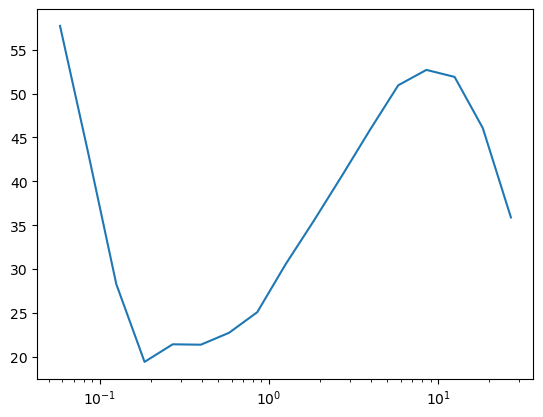

In [9]:
from matplotlib import pyplot as plt
rp, wp = result(return_sep=True, pimax=80)

plt.semilogx(rp,rp*wp)

In [10]:
edges = np.array([ 0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
         0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
         1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
         4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ,
        12.11527659, 14.67799268, 17.7827941 , 21.5443469 , 26.10157216,
        31.6227766 ]), np.linspace(-1,1,201)

result_smu = TwoPointCorrelationFunction('smu', edges, 
                                        data_positions1=[cat['x'], cat['y'], cat['z']],
                                        randoms_positions1=rd_pos.T, los='z', position_type='xyz',
                                        boxsize=None, nthreads=256)

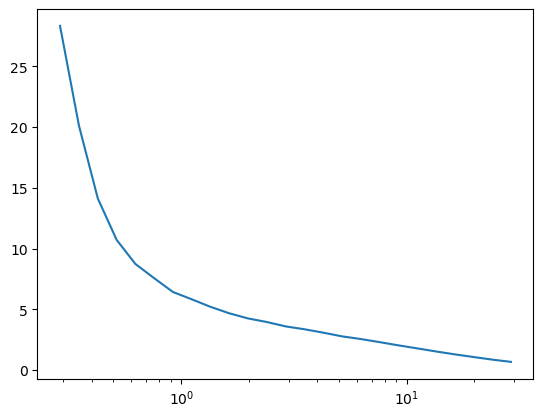

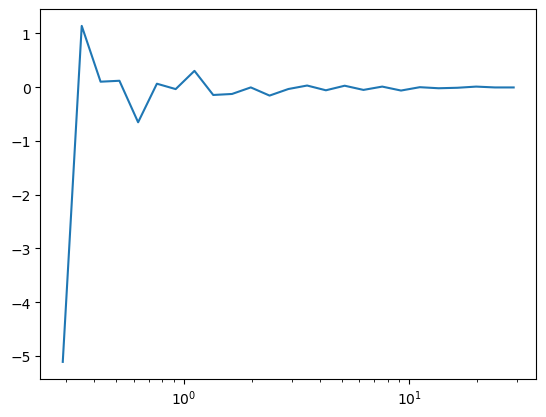

In [11]:
from matplotlib import pyplot as plt
s, (xi0, xi2) = result_smu(return_sep=True, ells=[0,2])

plt.semilogx(s,s*xi0)
plt.show()
plt.semilogx(s,s*xi2)

In [16]:
rsd_factor = 1 / (1 / (1 + cat['redshift_interp']) * 100 * HOD_obj.cosmo.efunc(cat['redshift_interp']))
z_rsd = cat['z'] + rsd_factor*cat['vz']

In [17]:
pimax = 40
edges = np.array([ 0.04641589,  0.06812921,  0.1       ,  0.14677993,  0.21544347,
         0.31622777,  0.46415888,  0.68129207,  1.        ,  1.46779927,
         2.15443469,  3.16227766,  4.64158883,  6.81292069, 10.        ,
        14.67799268, 21.5443469 , 31.6227766]), np.linspace(-pimax,pimax,pimax*2+1)

result = TwoPointCorrelationFunction('rppi', edges, 
                                        data_positions1=[cat['x'], cat['y'], z_rsd],
                                        randoms_positions1=rd_pos.T, los='z', position_type='xyz',
                                        boxsize=None, nthreads=256)

In [18]:
edges = np.array([ 0.26101572,  0.31622777,  0.38311868,  0.46415888,  0.56234133,
         0.68129207,  0.82540419,  1.        ,  1.21152766,  1.46779927,
         1.77827941,  2.15443469,  2.61015722,  3.16227766,  3.83118685,
         4.64158883,  5.62341325,  6.81292069,  8.25404185, 10.        ,
        12.11527659, 14.67799268, 17.7827941 , 21.5443469 , 26.10157216,
        31.6227766 ]), np.linspace(-1,1,201)

result_smu_rsd = TwoPointCorrelationFunction('smu', edges, 
                                        data_positions1=[cat['x'], cat['y'], z_rsd],
                                        randoms_positions1=rd_pos.T, los='z', position_type='xyz',
                                        boxsize=None, nthreads=256)

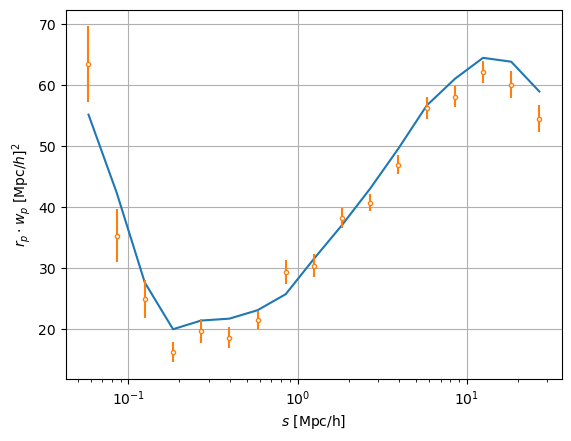

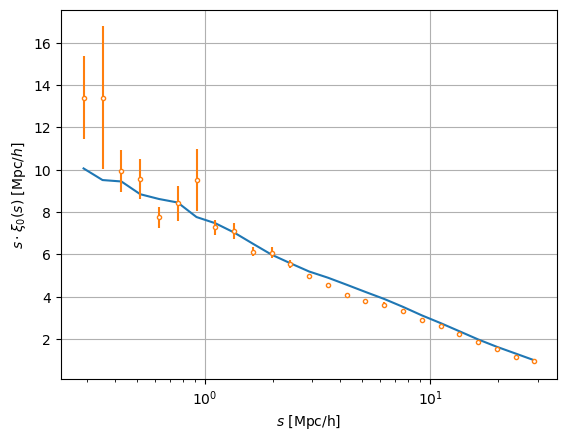

Text(0.5, 0, '$s$ [Mpc/h]')

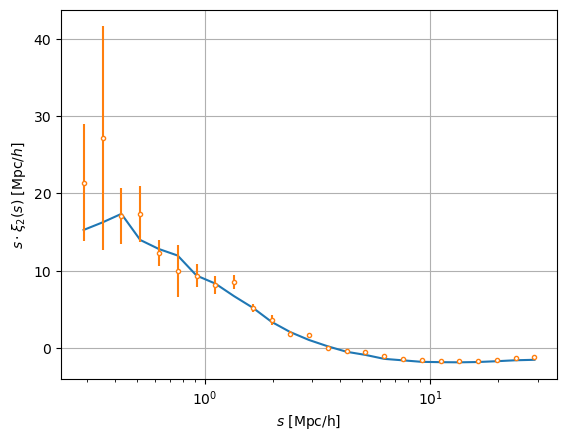

In [20]:
from matplotlib import pyplot as plt
s, (xi0, xi2) = result_smu_rsd(return_sep=True, ells=[0,2])




def read_pc(path_data = '/global/cfs/cdirs/desi/survey/catalogs/edav1/xi/sv3/',
            stat = 'rppi',
            tracer = 'ELG',
            region = 'NScomb',
            zlim = '0.8_1.6',
            njk = 128,
            nran = 18,
            weights = 'default_angular_bitwise_FKP',
            binning = 'log',
            split='_split20',
            fn=None,
            n_rebin = 1,
            n_rebin_post_cut=1,
            bin_inf=None,
            bin_sup=None):
    if fn is None:
        name = f'allcounts_{tracer}_{region}_{zlim}_{weights}_{binning}_njack{njk}_nran{nran}{split}.npy'
        fn = os.path.join(path_data, stat, name)
        return TwoPointCorrelationFunction.load(fn)[::n_rebin][bin_inf:bin_sup][::n_rebin_post_cut]
    else:
        return TwoPointCorrelationFunction.load(fn)[::n_rebin][bin_inf:bin_sup][::n_rebin_post_cut]
tr = 'ELG'
zbin = [0.8,1.1]
smu_res = read_pc(fn=f'/global/cfs/cdirs/desi/users/arocher/Y1/v1.5pip/smu/allcounts_{tr+"_LOPnotqso" if tr == "ELG" else tr}_GCcomb_{zbin[0]}_{zbin[1]}_pip_angular_bitwise_log_njack128_nran4_split20.npy',n_rebin=1, bin_inf=17, bin_sup=-6)
s_data, xi_data, sig_xi_data = smu_res(return_sep=True, return_std=True,  ells=[0,2])


rppi_res = read_pc(fn=f'/global/cfs/cdirs/desi/users/arocher/Y1/v1.5pip/rppi/allcounts_{tr+"_LOPnotqso" if tr == "ELG" else tr}_GCcomb_{zbin[0]}_{zbin[1]}_pip_angular_bitwise_log_njack128_nran4_split20.npy',n_rebin=2, bin_inf=4, bin_sup=-3)
rp_data, wp_data, sig_wp_data = rppi_res(return_sep=True, return_std=True,pimax=40)

rp, wp = result(return_sep=True, pimax=80)

plt.plot(rp,rp*wp)
plt.errorbar(rp_data,rp_data*wp_data, rp_data*sig_wp_data, fmt='.',
                        markerfacecolor='w')
plt.xscale('log')
plt.grid(True)
plt.ylabel('$r_{p} \cdot w_{p}$ [$\mathrm{{Mpc}}/h$]$^2$')
plt.xlabel('$s$ [Mpc/h]')
plt.show()

s, (xi0, xi2) = result_smu_rsd(return_sep=True, ells=[0,2])

plt.plot(s,s*xi0)
plt.errorbar(s_data,s_data*xi_data[0], s_data*sig_xi_data[0], fmt='.',
                        markerfacecolor='w')
plt.xscale('log')
plt.grid(True)
plt.ylabel(r'$s \cdot \xi_{{{:d}}}(s)$ [$\mathrm{{Mpc}}/h$]'.format(0))
plt.xlabel('$s$ [Mpc/h]')
plt.show()
plt.plot(s,s*xi2)
plt.errorbar(s_data,s_data*xi_data[1], s_data*sig_xi_data[1], fmt='.',
                        markerfacecolor='w')
plt.xscale('log')
plt.grid(True)
plt.ylabel(r'$s \cdot \xi_{{{:d}}}(s)$ [$\mathrm{{Mpc}}/h$]'.format(2))
plt.xlabel('$s$ [Mpc/h]')
